=== Welcome to the Corporate Finance Portfolio Optimizer Game ===

In this game, you will:
1. Explore a universe of generated investment assets and the Market Index.
2. Analyze these assets using the Capital Asset Pricing Model (CAPM).
3. Build your own investment portfolio (long/short individual assets and the Market Index).
4. Simulate your chosen portfolio's potential future performance (including VaR, CVaR, Semivariance).
5. Switch hats to a CFO and evaluate a corporate project with plausible cash flows using WACC.

Starting asset generation...
(Game using master seed: 36976 for asset generation)

--- Investment Opportunities Universe ---
#   Name                   Mean%   StdDev%    Beta  Sharpe  Treynor
-------------------------------------------------------------------
M  Market Index            0.55      3.38    1.00    0.09     0.00
-------------------------------------------------------------------
1   Corporate Bonds         0.39      1.58    0.20    0.09     0.01
2   Blue C

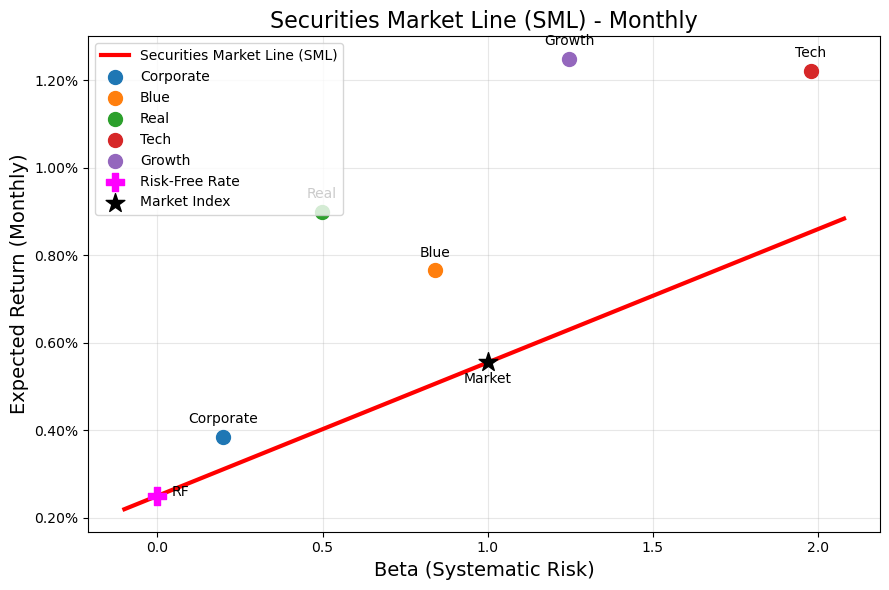


--- Portfolio Builder ---
Choose how to define your portfolio:

Available Portfolio Options:
  1) Custom weights (build your own - allows short selling up to -100%)
  2) Equal Weight Portfolio (across all available assets including Market Index) (Default - press Enter)

Enter the percentage for each asset (e.g., 50 for 50% long, -30 for 30% short).
Individual weights can be from -100% to +200% (example).
The final weights will be normalized to sum to 100%.

--- Custom Portfolio ---
Final Portfolio Allocation:
  Corporate Bonds: 10.00%
  Blue Chip Stocks: 10.00%
  Real Estate: 20.00%
  Tech Startups: 10.00%
  Growth Stocks: 40.00%
  Market Index: 10.00%
  Sum of final weights: 100.00%

Portfolio Statistics (Based on Historical Asset Data):
  Expected Monthly Return: 0.97%
  Monthly Standard Deviation: 3.78%
  Sharpe Ratio: 0.1909

--- Portfolio Monte Carlo Simulation (1000 paths, 12 months) ---
Starting Portfolio Value: $100,000.00
Portfolio Expected Monthly Return: 0.97%
Portfolio Mon

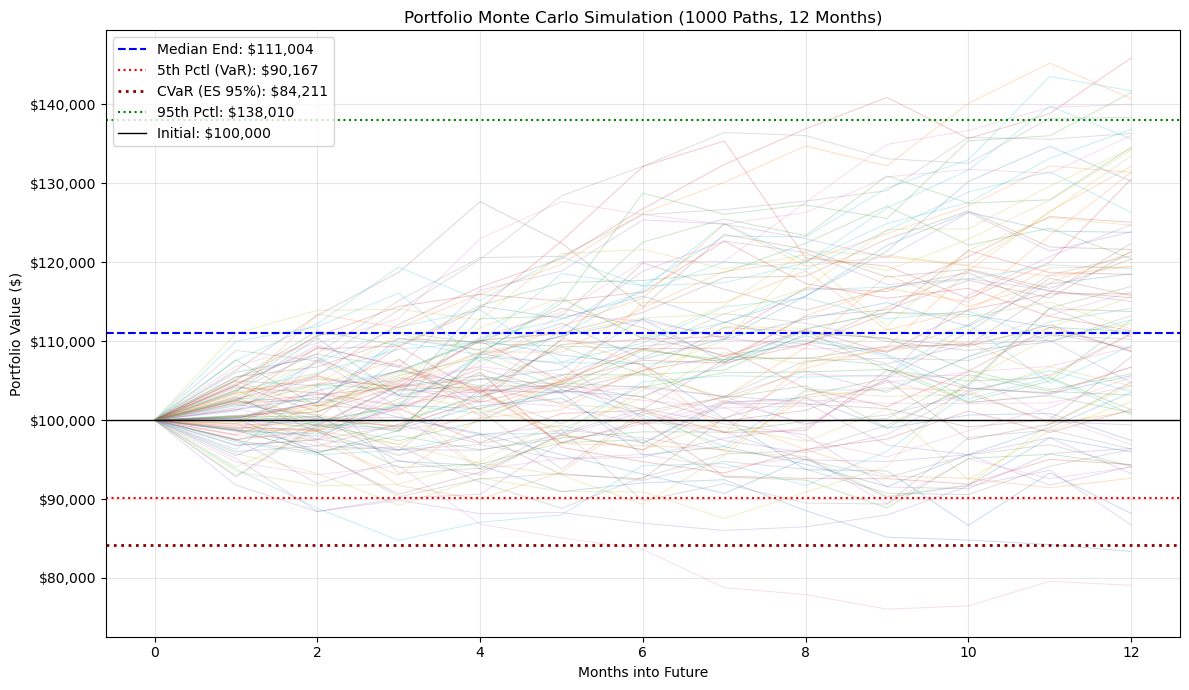

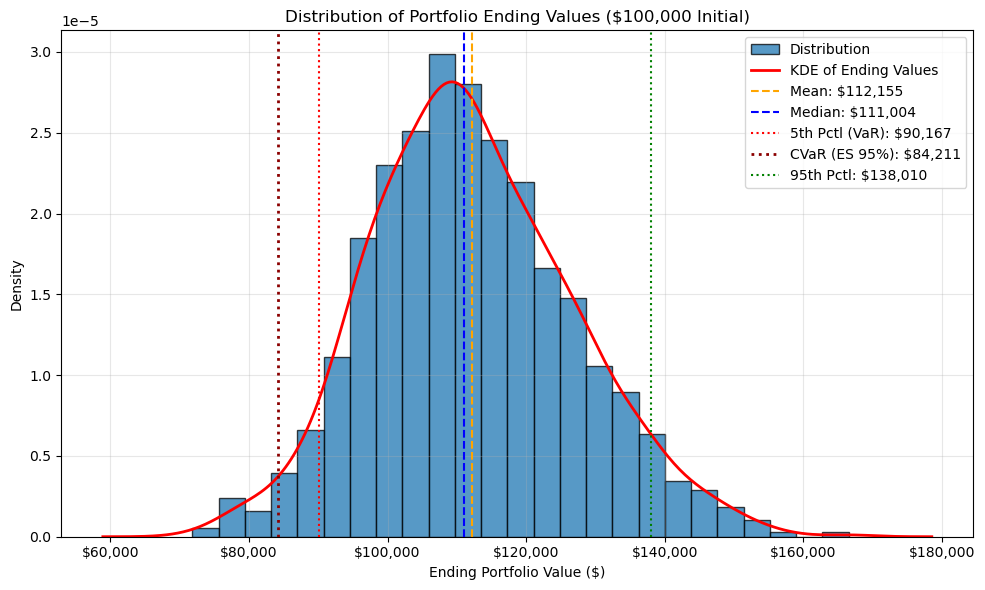


Simulation Results (Ending Values from Finite Paths):
  Number of valid simulation paths: 1000/1000
  Average Ending Value: $112,155.11
  Median Ending Value: $111,003.54
  5th Percentile (VaR 95%): $90,167.36
  CVaR 95% (Expected Shortfall): $84,211.40
  95th Percentile: $138,009.58
  Monthly Semivariance (vs Exp. Monthly Ret): 1.44e-03
  Monthly Semi-deviation (vs Exp. Monthly Ret): 3.79%
  Average Maximum Drawdown (from valid paths): 8.05%
  Worst Maximum Drawdown in any valid path: 34.45%
  Expected Total Return (from sim mean): 12.16%
  **Warning**: CVaR indicates that if a tail event occurs (worst 5% of cases), the average portfolio value could be significantly lower.

--- Project Evaluation Challenge ---
You are a CFO evaluating a potential corporate project using annual cash flows.

Project: IT System Overhaul
  Initial Investment: $4,340,000
  Project Beta: 0.78
  Project Life: 5 years (Ramp: 2y, Decline: 0y)
  Target Peak Annual CF (basis for generation): $1,467,831
  Sum of

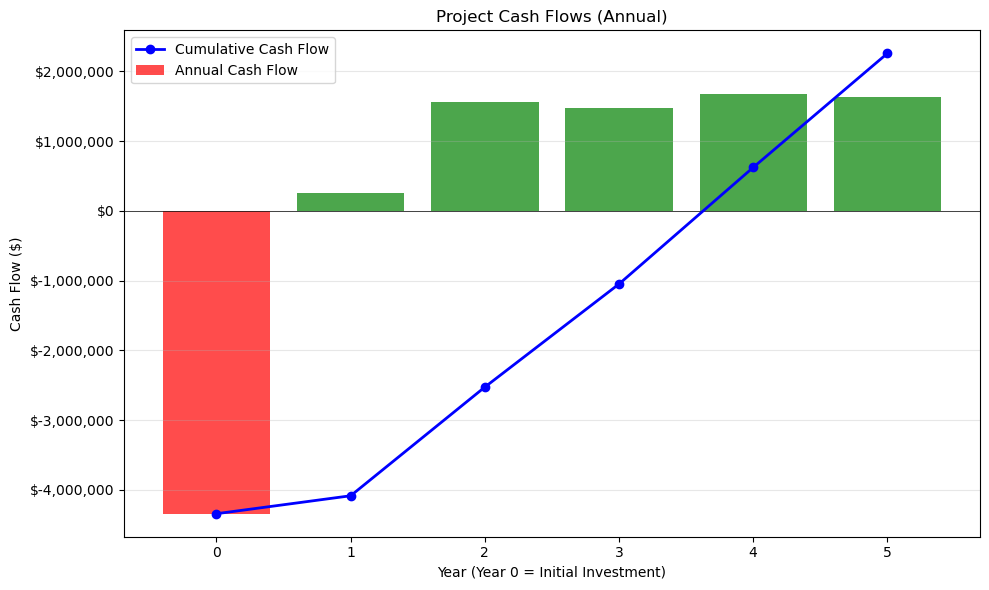


Project Evaluation Results:
  Net Present Value (NPV): $1,004,530
  Payback Period: 3.63 years
  Profitability Index (PI): 1.23

Decision Time: Based on this analysis, would you ACCEPT or REJECT this project?

Good call! Your decision aligns with the NPV rule.
  The positive NPV suggests the project is expected to create value.

Remember: NPV is often the primary criterion. Payback Period and PI provide additional insights.
Strategic factors and qualitative aspects also play a role in real-world decisions.


=== GAME COMPLETE ===
Thank you for playing the Corporate Finance Portfolio Optimizer Game!
Key concepts covered:
- Asset Characteristics & Generation (including Market Index as investable)
- Capital Asset Pricing Model (CAPM): Beta, Alpha, Securities Market Line (SML)
- Portfolio Construction & Diversification (custom weights, short selling, market bets)
- Monte Carlo Simulation: VaR, CVaR (Expected Shortfall), Semivariance, Max Drawdown
- Cost of Capital: Cost of Equity, WACC
- 

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import PercentFormatter
import pandas as pd
from scipy.optimize import minimize 
import warnings
import numpy as np

warnings.filterwarnings('ignore')

# --- Game Configuration ---
NUM_ASSETS = 5 
NUM_PERIODS_HISTORY = 60
NUM_SIM_PATHS = 1000
NUM_SIM_PERIODS_FUTURE = 12
MIN_ACCEPTABLE_SAMPLE_MEAN = 0.001
RISK_FREE_RATE = 0.0025  # Monthly risk-free rate (3% annual)

# --- Constants for Asset Generation Logic ---
MEAN_STD_RATIO_MIN = 0.10
TOLERANCE_FRACTION = 0.35
FALLBACK_MEAN_MAP = {
    "low": 0.003,
    "mid": 0.006,
    "high": 0.009
}

# --- Asset Archetypes Definition ---
ARCHETYPES = [
    {
        "name": "Government Bonds",
        "mean_rng": (0.0020, 0.0040),
        "std_rng": (0.005, 0.015),
        "dist": "normal",
        "skew_rng": (0.0, 0.3),
        "dof_rng": (12, 25),
        "beta_rng": (0.05, 0.25)
    },
    {
        "name": "Corporate Bonds", 
        "mean_rng": (0.0030, 0.0050),
        "std_rng": (0.010, 0.025),
        "dist": "normal",
        "skew_rng": (-0.2, 0.3),
        "dof_rng": (10, 20),
        "beta_rng": (0.15, 0.35)
    },
    {
        "name": "Blue Chip Stocks",
        "mean_rng": (0.005, 0.010),
        "std_rng": (0.025, 0.045),
        "dist": "normal",
        "skew_rng": (-0.3, 0.5),
        "dof_rng": (8, 15),
        "beta_rng": (0.70, 1.10)
    },
    {
        "name": "Growth Stocks",
        "mean_rng": (0.007, 0.015),
        "std_rng": (0.040, 0.070),
        "dist": "skew_norm",
        "skew_rng": (-0.6, 0.8),
        "dof_rng": (6, 12),
        "beta_rng": (1.00, 1.50)
    },
    {
        "name": "Tech Startups",
        "mean_rng": (0.009, 0.020),
        "std_rng": (0.060, 0.100),
        "dist": "student-t",
        "skew_rng": (-0.8, 1.0),
        "dof_rng": (4, 8),
        "beta_rng": (1.30, 2.00)
    },
    {
        "name": "Commodities",
        "mean_rng": (0.003, 0.012),
        "std_rng": (0.035, 0.080),
        "dist": "skew_norm",
        "skew_rng": (0.2, 1.2),
        "dof_rng": (5, 10),
        "beta_rng": (0.30, 0.70)
    },
    {
        "name": "Real Estate",
        "mean_rng": (0.004, 0.010),
        "std_rng": (0.020, 0.050),
        "dist": "normal",
        "skew_rng": (-0.2, 0.4),
        "dof_rng": (8, 15),
        "beta_rng": (0.40, 0.80)
    }
]

# --- Market Index for CAPM ---
MARKET_INDEX = {
    "name": "Market Index",
    "mean_rng": (0.006, 0.009), # Slightly increased upper bound for target mean
    "std_rng": (0.030, 0.040),
    "dist": "normal",
    "skew_rng": (-0.2, 0.2),
    "dof_rng": (10, 15)
}
    
# --- 2. Asset and Market Generation ---
def _draw_returns(arch, mean, std, n, rng):
    if arch["dist"] == "normal":
        return rng.normal(mean, std, n)
    if arch["dist"] == "skew_norm":
        a = rng.uniform(*arch["skew_rng"])
        return stats.skewnorm.rvs(a, loc=mean, scale=std, size=n, random_state=rng)
    # student-t (default)
    df = int(rng.integers(*arch["dof_rng"]))
    safe_df = max(3, df) 
    scale = std * np.sqrt((safe_df - 2) / safe_df) if safe_df > 2 else std
    return stats.t.rvs(safe_df, loc=mean, scale=scale, size=n, random_state=rng)

def generate_market_returns(periods=NUM_PERIODS_HISTORY, seed=None):
    rng = np.random.default_rng(seed)
    # Target mean for market is already set to be above RISK_FREE_RATE
    # MARKET_INDEX["mean_rng"] = (0.006, 0.009) vs RISK_FREE_RATE = 0.0025
    μ_target = rng.uniform(*MARKET_INDEX["mean_rng"])
    σ_target = rng.uniform(*MARKET_INDEX["std_rng"])

    market_rets = None
    m_sample = -np.inf # Initialize to ensure loop runs at least once
    s_sample = σ_target # Default std to target if loop fails badly

    max_retries_market = 20
    for attempt in range(max_retries_market):
        market_rets = _draw_returns(MARKET_INDEX, μ_target, σ_target, periods, rng)
        m_sample = market_rets.mean()
        if m_sample > RISK_FREE_RATE:
            s_sample = market_rets.std(ddof=0)
            break
        # If attempt is last and still not good, adjust on the last try
        if attempt == max_retries_market - 1 and m_sample <= RISK_FREE_RATE:
            print(f"Warning: Market sample mean ({m_sample:.4%}) was not > RF ({RISK_FREE_RATE:.4%}) after {max_retries_market} attempts.")
            # Force adjustment to ensure a positive market risk premium
            shift_needed = (RISK_FREE_RATE + 0.0005) - m_sample # Ensure at least 0.05% premium
            market_rets += shift_needed
            m_sample = market_rets.mean()
            s_sample = market_rets.std(ddof=0)
            print(f"  Artificially shifted market returns. New sample mean: {m_sample:.4%}")
            break # Exit loop after adjustment

    return {
        "name": MARKET_INDEX["name"],
        "returns": market_rets,
        "mean_return": m_sample,
        "std_dev": s_sample,
        "skewness": stats.skew(market_rets),
        "kurtosis": stats.kurtosis(market_rets),
        "beta": 1.0, 
        "description": f"Market Index. μ≈{m_sample:.3%}, σ≈{s_sample:.2%}"
    }

def generate_asset_universe(market_returns_data, n_assets=NUM_ASSETS, periods=NUM_PERIODS_HISTORY, seed=None):
    rng = np.random.default_rng(seed)
    current_archetypes = ARCHETYPES.copy() 
    rng.shuffle(current_archetypes)
    assets = []
 
    for arch in current_archetypes[:n_assets]: 
        asset_generated_successfully = False
        for _ in range(30): 
            μ_target = rng.uniform(*arch["mean_rng"])
            σ_target = rng.uniform(*arch["std_rng"])

            if σ_target > 0 and μ_target > 0 and μ_target < MEAN_STD_RATIO_MIN * σ_target:
                μ_target = MEAN_STD_RATIO_MIN * σ_target
            elif μ_target <= 0:
                μ_target = MEAN_STD_RATIO_MIN * σ_target if σ_target > 0 else MIN_ACCEPTABLE_SAMPLE_MEAN

            target_beta = rng.uniform(*arch["beta_rng"])
            market_var = market_returns_data["std_dev"]**2
            # Ensure variance calculation doesn't go negative if sigma_target is very small
            variance_epsilon = max(0, σ_target**2 - (target_beta**2 * market_var))
            std_epsilon = np.sqrt(variance_epsilon)

            idiosyncratic_component = _draw_returns(arch, 0, std_epsilon, periods, rng)
            rets = target_beta * market_returns_data["returns"] + idiosyncratic_component
            rets = rets - rets.mean() + μ_target # Recenter to target mean

            m_sample, s_sample = rets.mean(), rets.std(ddof=0)
            # Beta calculation should use the actual market returns variance
            if market_var > 1e-9: # Avoid division by zero or tiny numbers
                cov_with_market = np.cov(rets, market_returns_data["returns"])[0, 1]
                realized_beta = cov_with_market / market_var
            else:
                realized_beta = target_beta # Fallback if market variance is effectively zero

            mean_ok = (m_sample >= MIN_ACCEPTABLE_SAMPLE_MEAN and
                       (abs(m_sample - μ_target) < TOLERANCE_FRACTION * abs(μ_target) if abs(μ_target) > 1e-6 else abs(m_sample - μ_target) < 0.001))
            std_ok = (s_sample > 0 and σ_target > 1e-9 and # Ensure target_std is not zero for relative check
                      (abs(s_sample - σ_target) < TOLERANCE_FRACTION * σ_target if σ_target > 1e-6 else abs(s_sample - σ_target) < 0.001)) or \
                      (σ_target <= 1e-9 and s_sample < 0.001) # If target std is zero, sample should be close to zero


            if mean_ok and std_ok:
                assets.append({
                    "name": arch["name"], "returns": rets, "mean_return": m_sample,
                    "std_dev": s_sample, "skewness": stats.skew(rets),
                    "kurtosis": stats.kurtosis(rets), "beta": realized_beta,
                    "description": f"Profile: {arch['name']}. μ≈{m_sample:.3%}, σ≈{s_sample:.2%}, β≈{realized_beta:.2f}"
                })
                asset_generated_successfully = True
                break

        if not asset_generated_successfully: 
            band = ("low" if arch["std_rng"][1] < 0.02
                    else "mid" if arch["std_rng"][1] < 0.05
                    else "high")
            μ_fb = FALLBACK_MEAN_MAP.get(band, 0.005)
            σ_fb = arch["std_rng"][0]
            if σ_fb <= 0: σ_fb = 0.01

            target_beta_fb = (arch["beta_rng"][0] + arch["beta_rng"][1]) / 2
            base_rets_fb = rng.normal(0, σ_fb, periods) # Fallback to normal
            market_component_fb = target_beta_fb * (market_returns_data["returns"] - market_returns_data["mean_return"])
            
            # Ensure term inside sqrt is non-negative
            idiosyncratic_variance_factor = max(0, 1 - target_beta_fb**2)
            idiosyncratic_component_fb = np.sqrt(idiosyncratic_variance_factor) * base_rets_fb

            rets_fb = market_component_fb + idiosyncratic_component_fb
            rets_fb = rets_fb - rets_fb.mean() + μ_fb

            m_fb, s_fb = rets_fb.mean(), rets_fb.std(ddof=0)
            if market_var > 1e-9:
                cov_fb = np.cov(rets_fb, market_returns_data["returns"])[0,1]
                realized_beta_fb = cov_fb / market_var
            else:
                realized_beta_fb = target_beta_fb

            assets.append({
                "name": f"{arch['name']} (Fallback)", "returns": rets_fb,
                "mean_return": m_fb, "std_dev": s_fb,
                "skewness": stats.skew(rets_fb), "kurtosis": stats.kurtosis(rets_fb),
                "beta": realized_beta_fb,
                "description": f"Fallback. μ≈{m_fb:.3%}, σ≈{s_fb:.2%}, β≈{realized_beta_fb:.2f}" 
            })
    return sorted(assets, key=lambda a: a["mean_return"])

# --- 3. Display Asset Statistics and Visuals ---
# ... (display_assets_info function as before) ...
def display_assets_info(assets_list, market_data, risk_free_rate):
    if not assets_list:
        print("No assets available to display.")
        return

    print("\n--- Investment Opportunities Universe ---")
    market_risk_premium = market_data["mean_return"] - risk_free_rate
    market_sharpe = market_risk_premium / market_data["std_dev"] if market_data["std_dev"] > 0 else 0
    
    items_for_table_len_calc = assets_list + [market_data]
    max_name_len = max(len(item['name']) for item in items_for_table_len_calc) if items_for_table_len_calc else 20
    max_name_len = min(max_name_len, 35)
    if max_name_len < 20: max_name_len = 20

    header = f"{'#':<3} {'Name':<{max_name_len}} {'Mean%':>7} {'StdDev%':>9} {'Beta':>7} {'Sharpe':>7} {'Treynor':>8}"
    print(header); print("-" * len(header))
    mean_pct_mkt = market_data['mean_return'] * 100
    stddev_pct_mkt = market_data['std_dev'] * 100
    beta_mkt = market_data['beta'] 
    print(f"M  {market_data['name']:<{max_name_len}} {mean_pct_mkt:>7.2f} {stddev_pct_mkt:>9.2f} {beta_mkt:>7.2f} {market_sharpe:>7.2f} {market_risk_premium / beta_mkt if beta_mkt != 0 else 0:>8.2f}")
    print("-" * len(header))
    for i, asset in enumerate(assets_list): 
        mean_pct = asset['mean_return'] * 100
        stddev_pct = asset['std_dev'] * 100
        beta = asset['beta']
        risk_premium = asset['mean_return'] - risk_free_rate
        sharpe = risk_premium / asset['std_dev'] if asset['std_dev'] > 0 else 0
        treynor = risk_premium / beta if beta != 0 else 0
        print(f"{i+1:<3} {asset['name']:<{max_name_len}} {mean_pct:>7.2f} {stddev_pct:>9.2f} {beta:>7.2f} {sharpe:>7.2f} {treynor:>8.2f}")
    print("-" * len(header))
    rf_annual = (1 + risk_free_rate)**12 - 1
    print(f"\nRisk-Free Rate: {risk_free_rate*100:.2f}% monthly ({rf_annual*100:.2f}% annualized)")
    
    print("\n--- Asset Correlation Matrix (Generated Assets) ---")
    if len(assets_list) > 1:
        asset_names_corr = [a["name"].split(" ")[0] for a in assets_list] 
        all_returns_for_corr = np.column_stack([a["returns"] for a in assets_list])
        corr_matrix = np.corrcoef(all_returns_for_corr.T)
        corr_df = pd.DataFrame(corr_matrix, index=asset_names_corr, columns=asset_names_corr)
        print(corr_df.round(2))
    else:
        print("Not enough generated assets to compute their correlation matrix.")

# --- 5. CAPM Analysis ---
# ... (print_capm_analysis_table and generate_and_show_sml_plot as before) ...
def print_capm_analysis_table(assets_list, market_data, risk_free_rate):
    if not assets_list:
        print("CAPM Analysis: No assets provided for table.")
        return None, None
    print("\n--- Capital Asset Pricing Model (CAPM) Analysis ---")
    market_risk_premium_monthly = market_data["mean_return"] - risk_free_rate
    print(f"Market Risk Premium (Monthly): {market_risk_premium_monthly*100:.2f}%")
    print(f"\n{'Asset':<30} {'Actual Mean%':>15} {'CAPM Expected%':>15} {'Alpha%':>10} {'Beta':>8}")
    print("-" * 80)
    plot_data = {"betas": [], "actual_returns": [], "names_short": []}
    for asset in assets_list: 
        beta = asset["beta"]
        capm_expected_return = risk_free_rate + beta * market_risk_premium_monthly
        alpha = asset["mean_return"] - capm_expected_return
        actual_pct = asset["mean_return"] * 100
        expected_pct = capm_expected_return * 100
        alpha_pct = alpha * 100
        print(f"{asset['name']:<30} {actual_pct:>15.2f} {expected_pct:>15.2f} {alpha_pct:>10.2f} {beta:>8.2f}")
        plot_data["betas"].append(beta)
        plot_data["actual_returns"].append(asset["mean_return"])
        plot_data["names_short"].append(asset["name"].split(" ")[0]) 
    return plot_data, market_risk_premium_monthly

def generate_and_show_sml_plot(plot_data, market_data, risk_free_rate, market_risk_premium_monthly):
    if not plot_data or not plot_data["betas"]:
        print("SML Plot: No data to plot.")
        return
    asset_betas = plot_data["betas"]
    asset_actual_returns = plot_data["actual_returns"]
    asset_names_short = plot_data["names_short"]
    plt.figure(figsize=(9, 6))
    all_plotted_betas = asset_betas + [0, 1.0] 
    min_beta_plot = min(all_plotted_betas) - 0.1
    max_beta_plot = max(all_plotted_betas) + 0.1
    sml_x_points = np.array([min_beta_plot, max_beta_plot])
    sml_y_points = risk_free_rate + sml_x_points * market_risk_premium_monthly
    plt.plot(sml_x_points, sml_y_points, 'r-', linewidth=3, label='Securities Market Line (SML)', zorder=3)
    for i in range(len(asset_betas)): 
        plt.scatter(asset_betas[i], asset_actual_returns[i], s=100, label=asset_names_short[i] if i < 5 else None, zorder=5)
        if i < 5: 
             plt.annotate(asset_names_short[i], (asset_betas[i], asset_actual_returns[i]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.scatter(0, risk_free_rate, s=150, marker='P', color='magenta', label='Risk-Free Rate', zorder=5)
    plt.annotate("RF", (0, risk_free_rate), textcoords="offset points", xytext=(10,0), ha='left')
    plt.scatter(1.0, market_data["mean_return"], s=200, marker='*', color='black', label=market_data["name"], zorder=5)
    plt.annotate("Market", (1.0, market_data["mean_return"]), textcoords="offset points", xytext=(0,-15), ha='center')
    plt.title('Securities Market Line (SML) - Monthly', fontsize=16)
    plt.xlabel('Beta (Systematic Risk)', fontsize=14)
    plt.ylabel('Expected Return (Monthly)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper left')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.tight_layout()
    plt.show(block=False)

# --- 6. Portfolio Simulation ---
# ... (run_portfolio_simulation function as before) ...
def run_portfolio_simulation(portfolio_weights, assets_for_simulation, num_paths=NUM_SIM_PATHS, num_periods=NUM_SIM_PERIODS_FUTURE):
    portfolio_weights = np.array(portfolio_weights)
    if not assets_for_simulation or portfolio_weights.size == 0:
        print("Portfolio Simulation: No assets or weights provided.")
        return None

    all_asset_returns_hist = np.column_stack([a["returns"] for a in assets_for_simulation])
    asset_mean_returns = np.array([a["mean_return"] for a in assets_for_simulation])
    
    if all_asset_returns_hist.shape[1] == 1: 
        asset_cov_matrix = np.array([[np.var(all_asset_returns_hist[:,0])]])
    else:
        asset_cov_matrix = np.cov(all_asset_returns_hist.T)

    if len(portfolio_weights) != len(asset_mean_returns):
        print(f"Error: Number of weights ({len(portfolio_weights)}) does not match number of assets in simulation ({len(asset_mean_returns)}).")
        return None

    portfolio_expected_monthly_return = np.sum(portfolio_weights * asset_mean_returns) 
    portfolio_variance = np.dot(portfolio_weights.T, np.dot(asset_cov_matrix, portfolio_weights))
    portfolio_std_dev = np.sqrt(max(0, portfolio_variance))
    
    asset_betas_for_calc = np.array([a['beta'] for a in assets_for_simulation])
    portfolio_beta = np.sum(portfolio_weights * asset_betas_for_calc)
    initial_investment = 100_000

    print(f"\n--- Portfolio Monte Carlo Simulation ({num_paths} paths, {num_periods} months) ---")
    print(f"Starting Portfolio Value: ${initial_investment:,.2f}")
    print(f"Portfolio Expected Monthly Return: {portfolio_expected_monthly_return:.2%}")
    print(f"Portfolio Monthly Volatility: {portfolio_std_dev:.2%}")
    print(f"Portfolio Beta: {portfolio_beta:.2f}")

    print("\nPortfolio Asset Allocation:")
    for w, asset in zip(portfolio_weights, assets_for_simulation): 
        if abs(w) > 1e-5:
            print(f"  {asset['name']}: {w:.2%}")
            
    rng = np.random.default_rng()
    simulated_paths_values = np.zeros((num_paths, num_periods + 1))
    simulated_paths_values[:, 0] = initial_investment
    all_simulated_period_returns = []

    for i in range(num_paths):
        try:
            eigenvalues = np.linalg.eigvalsh(asset_cov_matrix)
            current_cov_matrix = asset_cov_matrix
            if np.any(eigenvalues < -1e-9):
                 current_cov_matrix = asset_cov_matrix + np.eye(len(asset_mean_returns)) * 1e-7
            elif np.any(eigenvalues < 1e-9):
                 current_cov_matrix = asset_cov_matrix + np.eye(len(asset_mean_returns)) * 1e-9
            multi_asset_returns = rng.multivariate_normal(asset_mean_returns, current_cov_matrix, size=num_periods)
        except np.linalg.LinAlgError as e:
            jittered_cov_matrix = asset_cov_matrix + np.eye(len(asset_mean_returns)) * 1e-6 
            try:
                multi_asset_returns = rng.multivariate_normal(asset_mean_returns, jittered_cov_matrix, size=num_periods)
            except np.linalg.LinAlgError as e2:
                print(f"CRITICAL: Simulation failed even with jitter for path {i}: {e2}. Path will be flat.")
                simulated_paths_values[i, 1:] = initial_investment 
                all_simulated_period_returns.extend([0.0] * num_periods) 
                continue
        
        portfolio_path_period_returns = np.sum(multi_asset_returns * portfolio_weights, axis=1)
        all_simulated_period_returns.extend(portfolio_path_period_returns) 

        current_value = initial_investment
        for t in range(num_periods):
            current_value *= (1 + portfolio_path_period_returns[t])
            simulated_paths_values[i, t+1] = current_value
            if not np.isfinite(current_value):
                simulated_paths_values[i, t+1:] = simulated_paths_values[i, t] if t > 0 and np.isfinite(simulated_paths_values[i,t]) else initial_investment
                break
    
    all_simulated_period_returns = np.array(all_simulated_period_returns)
    finite_ending_values = simulated_paths_values[:, -1][np.isfinite(simulated_paths_values[:, -1])]

    if len(finite_ending_values) < num_paths * 0.1: 
        print(f"CRITICAL: Too many simulation paths ({num_paths - len(finite_ending_values)}) resulted in non-finite values. Results may be unreliable.")
        if len(finite_ending_values) == 0: 
            print("No valid simulation paths. Skipping statistics and plots for ending values distribution.")
            return {'paths': simulated_paths_values, 'ending_values': simulated_paths_values[:, -1], 
                    'statistics': {'num_valid_paths': 0}}

    mean_final_value = np.mean(finite_ending_values) if len(finite_ending_values) > 0 else initial_investment
    median_final_value = np.median(finite_ending_values) if len(finite_ending_values) > 0 else initial_investment
    percentile_5th_var = np.percentile(finite_ending_values, 5) if len(finite_ending_values) > 0 else initial_investment
    percentile_95th = np.percentile(finite_ending_values, 95) if len(finite_ending_values) > 0 else initial_investment
    losses_below_var = finite_ending_values[finite_ending_values <= percentile_5th_var]
    cvar_95 = np.mean(losses_below_var) if len(losses_below_var) > 0 else percentile_5th_var
    downside_returns = all_simulated_period_returns[all_simulated_period_returns < portfolio_expected_monthly_return]
    semivariance_monthly = np.mean((downside_returns - portfolio_expected_monthly_return)**2) if len(downside_returns) > 0 else 0.0
    semi_deviation_monthly = np.sqrt(semivariance_monthly)
    max_drawdowns = []
    for path_idx in range(num_paths):
        path_values = simulated_paths_values[path_idx, :]
        finite_path_values = path_values[np.isfinite(path_values)]
        if len(finite_path_values) < 2 : continue
        peak_value = finite_path_values[0]
        max_dd_for_path = 0
        for val_idx in range(1, len(finite_path_values)):
            current_val = finite_path_values[val_idx]
            if current_val > peak_value: peak_value = current_val
            drawdown = (peak_value - current_val) / peak_value if peak_value > 1e-9 else 0
            if drawdown > max_dd_for_path: max_dd_for_path = drawdown
        max_drawdowns.append(max_dd_for_path)
    avg_max_drawdown = np.mean(max_drawdowns) if max_drawdowns else 0
    worst_drawdown_overall = np.max(max_drawdowns) if max_drawdowns else 0

    plt.figure(figsize=(12, 7))
    paths_to_plot = min(100, num_paths)
    for i in range(paths_to_plot):
        plt.plot(np.arange(num_periods + 1), simulated_paths_values[i, :], lw=0.7, alpha=0.25)
    plt.axhline(median_final_value, color='blue', linestyle='--', linewidth=1.5, label=f"Median End: ${median_final_value:,.0f}")
    plt.axhline(percentile_5th_var, color='red', linestyle=':', linewidth=1.5, label=f"5th Pctl (VaR): ${percentile_5th_var:,.0f}")
    plt.axhline(cvar_95, color='darkred', linestyle=':', linewidth=2, label=f"CVaR (ES 95%): ${cvar_95:,.0f}")
    plt.axhline(percentile_95th, color='green', linestyle=':', linewidth=1.5, label=f"95th Pctl: ${percentile_95th:,.0f}")
    plt.axhline(initial_investment, color='black', linestyle='-', linewidth=1, label=f"Initial: ${initial_investment:,.0f}")
    plt.title(f"Portfolio Monte Carlo Simulation ({num_paths} Paths, {num_periods} Months)")
    plt.xlabel("Months into Future"); plt.ylabel("Portfolio Value ($)")
    plt.grid(True, alpha=0.3); plt.legend(loc='upper left')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    plt.tight_layout(); plt.show(block=False)

    plt.figure(figsize=(10, 6))
    if len(finite_ending_values) > 1:
        plt.hist(finite_ending_values, bins='auto', alpha=0.75, density=True, edgecolor='black', label="Distribution")
        try:
            data_std_debug = np.std(finite_ending_values)
            if len(np.unique(finite_ending_values)) > 1 and data_std_debug > 1e-3 : 
                kde = stats.gaussian_kde(finite_ending_values)
                if (np.max(finite_ending_values) - np.min(finite_ending_values)) < 1: 
                    kde_x_min = np.min(finite_ending_values) - 1
                    kde_x_max = np.max(finite_ending_values) + 1
                else:
                    kde_x_min = percentile_5th_var - (median_final_value - percentile_5th_var) * 1.5 
                    kde_x_max = percentile_95th + (percentile_95th - median_final_value) * 1.5
                if kde_x_min >= kde_x_max : kde_x_max = kde_x_min + max(1, abs(kde_x_min*0.1)) 
                x_kde = np.linspace(kde_x_min, kde_x_max, 300)
                plt.plot(x_kde, kde(x_kde), 'r-', lw=2, label="KDE of Ending Values")
        except Exception as e: print(f"Could not generate KDE plot for ending values: {e}")
    else: print("Not enough data points to plot histogram/KDE of ending values.")
    plt.axvline(mean_final_value, color='orange', linestyle='--', linewidth=1.5, label=f"Mean: ${mean_final_value:,.0f}")
    plt.axvline(median_final_value, color='blue', linestyle='--', linewidth=1.5, label=f"Median: ${median_final_value:,.0f}")
    plt.axvline(percentile_5th_var, color='red', linestyle=':', linewidth=1.5, label=f"5th Pctl (VaR): ${percentile_5th_var:,.0f}")
    plt.axvline(cvar_95, color='darkred', linestyle=':', linewidth=2, label=f"CVaR (ES 95%): ${cvar_95:,.0f}")
    plt.axvline(percentile_95th, color='green', linestyle=':', linewidth=1.5, label=f"95th Pctl: ${percentile_95th:,.0f}")
    plt.title(f"Distribution of Portfolio Ending Values (${initial_investment:,.0f} Initial)")
    plt.xlabel("Ending Portfolio Value ($)"); plt.ylabel("Density")
    plt.grid(True, alpha=0.3); plt.legend(loc='best')
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    plt.tight_layout(); plt.show(block=False)

    print("\nSimulation Results (Ending Values from Finite Paths):")
    print(f"  Number of valid simulation paths: {len(finite_ending_values)}/{num_paths}")
    print(f"  Average Ending Value: ${mean_final_value:,.2f}")
    print(f"  Median Ending Value: ${median_final_value:,.2f}")
    print(f"  5th Percentile (VaR 95%): ${percentile_5th_var:,.2f}")
    print(f"  CVaR 95% (Expected Shortfall): ${cvar_95:,.2f}")
    print(f"  95th Percentile: ${percentile_95th:,.2f}")
    print(f"  Monthly Semivariance (vs Exp. Monthly Ret): {semivariance_monthly:.2e}")
    print(f"  Monthly Semi-deviation (vs Exp. Monthly Ret): {semi_deviation_monthly:.2%}")
    print(f"  Average Maximum Drawdown (from valid paths): {avg_max_drawdown:.2%}")
    print(f"  Worst Maximum Drawdown in any valid path: {worst_drawdown_overall:.2%}")
    expected_total_return_sim = (mean_final_value / initial_investment) - 1 if initial_investment > 1e-9 else 0
    print(f"  Expected Total Return (from sim mean): {expected_total_return_sim:.2%}")
    if percentile_5th_var < initial_investment * 0.90: print("\n  *Note*: Simulation shows a possibility of losses (5th percentile below 90% of initial).")
    if cvar_95 < initial_investment * 0.85 : print("  **Warning**: CVaR indicates that if a tail event occurs (worst 5% of cases), the average portfolio value could be significantly lower.")
    return {'paths': simulated_paths_values, 'ending_values': finite_ending_values,
            'statistics': {'mean': mean_final_value, 'median': median_final_value,
                           'percentile_5th_var': percentile_5th_var, 'cvar_95': cvar_95,
                           'percentile_95th': percentile_95th,
                           'semivariance_monthly': semivariance_monthly, 'semi_deviation_monthly': semi_deviation_monthly,
                           'avg_max_drawdown': avg_max_drawdown, 'worst_drawdown': worst_drawdown_overall,
                           'num_valid_paths': len(finite_ending_values)}}

# --- 7. Calculate Cost of Capital ---
# ... (calculate_cost_of_capital function as before) ...
def calculate_cost_of_capital(beta, risk_free_rate_monthly, market_data, debt_ratio_dec, cost_of_debt_dec_annual, tax_rate_dec):
    risk_free_rate_annual = (1 + risk_free_rate_monthly)**12 - 1
    market_mean_return_annual = (1 + market_data["mean_return"])**12 - 1
    market_risk_premium_annual = market_mean_return_annual - risk_free_rate_annual
    cost_of_equity_annual = risk_free_rate_annual + beta * market_risk_premium_annual
    equity_ratio = 1 - debt_ratio_dec
    wacc_annual = (equity_ratio * cost_of_equity_annual) + (debt_ratio_dec * cost_of_debt_dec_annual * (1 - tax_rate_dec))
    unlevered_beta = beta / (1 + (1 - tax_rate_dec) * (debt_ratio_dec / equity_ratio)) if equity_ratio > 1e-9 else beta
    return {
        'equity_cost_annual': cost_of_equity_annual, 'debt_cost_annual': cost_of_debt_dec_annual,
        'debt_ratio': debt_ratio_dec, 'tax_rate': tax_rate_dec, 'wacc_annual': wacc_annual, 
        'unlevered_beta': unlevered_beta, 'risk_free_rate_annual': risk_free_rate_annual,
        'market_risk_premium_annual': market_risk_premium_annual
    }

# --- 8. Project Evaluation using WACC ---
# ... (evaluate_project function as before, with IRR parts removed/commented) ...
def evaluate_project(initial_investment, cash_flows_annual, wacc_annual, plot=True):
    npv = -initial_investment
    for t, cf in enumerate(cash_flows_annual):
        npv += cf / ((1 + wacc_annual) ** (t + 1))
    
    cumulative_cf_calc = -initial_investment 
    payback_period_years = None
    prev_cumulative_cf_for_payback = cumulative_cf_calc 
    for t, cf_val in enumerate(cash_flows_annual): 
        current_period_cumulative_cf = prev_cumulative_cf_for_payback + cf_val
        if current_period_cumulative_cf >= -1e-9 and payback_period_years is None:
            if abs(cf_val) < 1e-9 : 
                 payback_period_years = (t + 1) if prev_cumulative_cf_for_payback < -1e-9 else t 
            else:
                payback_period_years = t + (-prev_cumulative_cf_for_payback / cf_val) 
            break
        prev_cumulative_cf_for_payback = current_period_cumulative_cf
        
    pv_inflows = np.sum([cf / ((1 + wacc_annual)**(t+1)) for t, cf in enumerate(cash_flows_annual)])
    profitability_index = pv_inflows / abs(initial_investment) if abs(initial_investment) > 1e-9 else 0

    if plot:
        plt.figure(figsize=(10, 6))
        periods = list(range(len(cash_flows_annual) + 1)) 
        all_flows_for_plot = [-initial_investment] + cash_flows_annual 
        bar_colors = ['red' if cf < 0 else 'green' for cf in all_flows_for_plot]
        plt.bar(periods, all_flows_for_plot, color=bar_colors, alpha=0.7, label="Annual Cash Flow")
        plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
        cumulative_plot_flows = np.cumsum(all_flows_for_plot)
        plt.plot(periods, cumulative_plot_flows, marker='o', color='blue', linestyle='-', linewidth=2, label='Cumulative Cash Flow')
        plt.title('Project Cash Flows (Annual)')
        plt.xlabel('Year (Year 0 = Initial Investment)')
        plt.ylabel('Cash Flow ($)')
        plt.grid(True, alpha=0.3, axis='y')
        plt.legend()
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        max_year_tick = len(cash_flows_annual)
        plt.xticks(np.arange(0, max_year_tick + 1, 1 if max_year_tick <=10 else (2 if max_year_tick <=20 else 5) ))
        plt.tight_layout()
        plt.show(block=False)

    return {
        'npv': npv, 
        'payback_period_years': payback_period_years,
        'profitability_index': profitability_index
    }

# --- 9. User Portfolio Builder ---
# ... (build_user_portfolio function as modified for short selling, default, and cumulative weight display) ...
def build_user_portfolio(assets_for_construction, risk_free_rate_param): 
    if not assets_for_construction:
        print("Portfolio Builder: No assets available.")
        return None, "No Portfolio"
    
    n_total_investable_assets = len(assets_for_construction)
    print("\n--- Portfolio Builder ---")
    print("Choose how to define your portfolio:")
    print("\nAvailable Portfolio Options:")
    print("  1) Custom weights (build your own - allows short selling up to -100%)") 
    print("  2) Equal Weight Portfolio (across all available assets including Market Index) (Default - press Enter)")

    user_portfolio_weights = []
    portfolio_name = "Undefined Portfolio"
    
    choice = ""
    while True:
        choice_input = input(f"Enter your choice (1-2 for {n_total_investable_assets} assets, or press Enter for Equal Weight): ").strip()
        if choice_input in ['1', '2', '']:
            choice = choice_input
            break
        else:
            print("Invalid choice. Please enter 1, 2, or press Enter for the default.")

    if choice == '': 
        choice = '2' 
        print(f"Defaulting to Equal Weight Portfolio across {n_total_investable_assets} investable items.")

    if choice == '1':
        portfolio_name = "Custom Portfolio"
        print("\nEnter the percentage for each asset (e.g., 50 for 50% long, -30 for 30% short).")
        print("Individual weights can be from -100% to +200% (example).")
        print("The final weights will be normalized to sum to 100%.")
        
        temp_weights_pct = []
        current_algebraic_sum_pct = 0.0 
        for i, asset_item in enumerate(assets_for_construction): 
            valid_weight_input = False
            while not valid_weight_input:
                try:
                    prompt_text = f"  Weight for {asset_item['name']} (Current sum of entered weights: {current_algebraic_sum_pct:.1f}%): "
                    weight_str = input(prompt_text)
                    weight_pct_val = float(weight_str)
                    
                    if -100.0 <= weight_pct_val <= 200.0: 
                        temp_weights_pct.append(weight_pct_val) # Add to list first
                        current_algebraic_sum_pct = sum(temp_weights_pct) # Then update sum for next prompt
                        valid_weight_input = True
                    else:
                        print("  Please enter a percentage between -100 and 200 (example bounds for initial input).")
                except ValueError:
                    print("  Please enter a valid number.")
        
        temp_weights_frac = [w / 100.0 for w in temp_weights_pct]
        total_algebraic_weight = sum(temp_weights_frac)
        
        if abs(total_algebraic_weight) > 1e-9: 
            user_portfolio_weights = [w / total_algebraic_weight for w in temp_weights_frac]
            capped_weights = []
            was_capped = False
            for i_cap, w_norm in enumerate(user_portfolio_weights):
                asset_name_for_cap_msg = assets_for_construction[i_cap]['name']
                if w_norm < -1.0:
                    print(f"Warning: Normalized weight for {asset_name_for_cap_msg} ({w_norm*100:.1f}%) is below -100%. Capping at -100%.")
                    capped_weights.append(-1.0)
                    was_capped = True
                else:
                    capped_weights.append(w_norm)
            if was_capped:
                user_portfolio_weights = capped_weights
                new_sum_after_cap = sum(user_portfolio_weights)
                if abs(new_sum_after_cap) > 1e-9 and abs(new_sum_after_cap - 1.0) > 0.001 : 
                    print(f"Note: Weights re-normalized after capping to ensure they sum to 100%. Original sum after cap: {new_sum_after_cap*100:.1f}%.")
                    user_portfolio_weights = [w / new_sum_after_cap for w in user_portfolio_weights]
        else: 
            print("  Total sum of input weights is zero. Defaulting to Equal Weight.")
            user_portfolio_weights = [1.0 / n_total_investable_assets] * n_total_investable_assets
            
    elif choice == '2':
        print(f"Selected: Equal Weight Portfolio across {n_total_investable_assets} items.")
        user_portfolio_weights = [1.0 / n_total_investable_assets] * n_total_investable_assets
        portfolio_name = "Equal Weight Portfolio"
    
    user_portfolio_weights = np.array(user_portfolio_weights)

    asset_mean_returns = np.array([a["mean_return"] for a in assets_for_construction])
    portfolio_return_hist = np.sum(user_portfolio_weights * asset_mean_returns)
    
    all_asset_returns_hist = np.column_stack([a["returns"] for a in assets_for_construction])

    if all_asset_returns_hist.shape[1] == 1:
        cov_matrix_hist = np.array([[np.var(all_asset_returns_hist[:,0])]])
    else:
        cov_matrix_hist = np.cov(all_asset_returns_hist.T)
    
    portfolio_std_dev_hist = np.sqrt(max(0, np.dot(user_portfolio_weights.T, np.dot(cov_matrix_hist, user_portfolio_weights))))
    portfolio_sharpe_hist = (portfolio_return_hist - risk_free_rate_param) / portfolio_std_dev_hist if portfolio_std_dev_hist > 1e-9 else 0

    print(f"\n--- {portfolio_name} ---")
    print("Final Portfolio Allocation:")
    for i, (w, asset) in enumerate(zip(user_portfolio_weights, assets_for_construction)):
        if abs(w) > 1e-5: 
            print(f"  {asset['name']}: {w:.2%}")
    print(f"  Sum of final weights: {sum(user_portfolio_weights)*100:.2f}%")

    print("\nPortfolio Statistics (Based on Historical Asset Data):")
    print(f"  Expected Monthly Return: {portfolio_return_hist:.2%}")
    print(f"  Monthly Standard Deviation: {portfolio_std_dev_hist:.2%}")
    print(f"  Sharpe Ratio: {portfolio_sharpe_hist:.4f}")

    return user_portfolio_weights, portfolio_name


# --- 10. Project Evaluation Game ---
# ... (project_evaluation_game function with modified CF generation and 125% constraint) ...
# ... and now with integer percentage inputs for WACC parameters
def project_evaluation_game(market_data, risk_free_rate_monthly):
    print("\n--- Project Evaluation Challenge ---")
    print("You are a CFO evaluating a potential corporate project using annual cash flows.")
    rng = np.random.default_rng()
    
    project_types = [
        {"name": "Factory Expansion", "beta_range": (0.8, 1.2), "inv_range": (5e6, 15e6), "cf_mean_frac_rng": (0.20, 0.30), "cf_std_frac": 0.12, "life": 10, "ramp_years_frac": 0.25, "decline_years_frac": 0.2}, 
        {"name": "New Product R&D", "beta_range": (1.1, 1.7), "inv_range": (2e6, 8e6), "cf_mean_frac_rng": (0.28, 0.45), "cf_std_frac": 0.18, "life": 7, "ramp_years_frac": 0.35, "decline_years_frac": 0.15}, 
        {"name": "IT System Overhaul", "beta_range": (0.6, 1.0), "inv_range": (1e6, 5e6), "cf_mean_frac_rng": (0.25, 0.38), "cf_std_frac": 0.10, "life": 5, "ramp_years_frac": 0.4, "decline_years_frac": 0}, 
        {"name": "Acquisition Target", "beta_range": (1.0, 1.5), "inv_range": (10e6, 50e6), "cf_mean_frac_rng": (0.18, 0.28), "cf_std_frac": 0.15, "life": 12, "ramp_years_frac": 0.2, "decline_years_frac": 0.25}, 
        {"name": "Sustainability Initiative", "beta_range": (0.5, 0.9), "inv_range": (3e6, 9e6), "cf_mean_frac_rng": (0.15, 0.28), "cf_std_frac": 0.10, "life": 15, "ramp_years_frac": 0.3, "decline_years_frac": 0.2} 
    ]
    project = rng.choice(project_types)
    project_beta = round(rng.uniform(*project["beta_range"]), 2)
    initial_investment_proj = round(rng.uniform(*project["inv_range"]), -4) 
    life = project["life"]
    
    max_retries_cf = 10
    generated_annual_cash_flows = [] 
    final_sum_operational_cf = 0

    for attempt in range(max_retries_cf):
        annual_cash_flows_attempt = []
        ramp_years = max(1, int(life * project["ramp_years_frac"])) 
        decline_years = int(life * project["decline_years_frac"])
        peak_start_year = ramp_years + 1
        decline_start_year = life - decline_years + 1
        if decline_start_year <= peak_start_year : 
            if life - ramp_years > 1 : 
                decline_start_year = peak_start_year + 1 
            else: 
                decline_start_year = life + 1 
            decline_years = max(0, life - decline_start_year + 1)

        selected_cf_mean_frac = rng.uniform(*project["cf_mean_frac_rng"])
        peak_operational_cf = initial_investment_proj * selected_cf_mean_frac 

        for year_num in range(1, life + 1): 
            target_mean_cf_for_year = 0
            std_dev_factor_for_year = 1.0

            if year_num <= ramp_years:
                ramp_progress = year_num / ramp_years
                ramp_factor = ramp_progress**1.3 
                target_mean_cf_for_year = peak_operational_cf * ramp_factor
                std_dev_factor_for_year = 0.4 + 0.6 * ramp_factor 
                if year_num == 1: 
                    target_mean_cf_for_year = peak_operational_cf * rng.uniform(0.10, 0.30) 
                    if rng.random() < 0.05: 
                         target_mean_cf_for_year = peak_operational_cf * rng.uniform(-0.02, 0.02)
            elif decline_years > 0 and year_num >= decline_start_year:
                year_in_decline = year_num - decline_start_year + 1
                decline_progress = min(1.0, year_in_decline / decline_years if decline_years > 0 else 1.0)
                decline_factor = 1.0 - decline_progress**1.2 
                target_mean_cf_for_year = peak_operational_cf * max(0.0, decline_factor) 
                std_dev_factor_for_year = 0.3 + 0.7 * max(0, decline_factor) 
            else: 
                target_mean_cf_for_year = peak_operational_cf
                std_dev_factor_for_year = 1.0

            cf_std_this_year = abs(peak_operational_cf * project["cf_std_frac"] * std_dev_factor_for_year)
            effective_std = max(0.01 * abs(peak_operational_cf) * project["cf_std_frac"] , cf_std_this_year)            
            cf_this_year = rng.normal(target_mean_cf_for_year, effective_std)
            
            if year_num == 1:
                cf_this_year = max(cf_this_year, -0.05 * peak_operational_cf if peak_operational_cf >0 else -1000) 
            else: 
                cf_this_year = max(cf_this_year, 0) 
            
            annual_cash_flows_attempt.append(round(cf_this_year, -2))

        final_sum_operational_cf = sum(annual_cash_flows_attempt) 
        generated_annual_cash_flows = annual_cash_flows_attempt
        
        if final_sum_operational_cf >= 1.25 * initial_investment_proj:
            break 
        if attempt == max_retries_cf - 1:
            print(f"Warning: Project CFs (sum: ${final_sum_operational_cf:,.0f}) did not meet 125% of investment (${initial_investment_proj*1.25:,.0f}) after {max_retries_cf} attempts. Using last set.")

    annual_cash_flows = generated_annual_cash_flows

    print(f"\nProject: {project['name']}")
    print(f"  Initial Investment: ${initial_investment_proj:,.0f}")
    print(f"  Project Beta: {project_beta:.2f}")
    print(f"  Project Life: {life} years (Ramp: {ramp_years}y, Decline: {decline_years}y)")
    print(f"  Target Peak Annual CF (basis for generation): ${peak_operational_cf:,.0f}")
    print(f"  Sum of Undiscounted Operational Cash Flows: ${sum(annual_cash_flows):,.0f} (Target was >= ${initial_investment_proj*1.25:,.0f})")
    print("\nTo evaluate, we need the Weighted Average Cost of Capital (WACC - Annual).")

    debt_ratio_dec, cost_of_debt_dec_annual, tax_rate_dec = 0.4, 0.05, 0.21 # Defaults

    try:
        debt_ratio_pct_str = input("  Enter target Debt-to-Total Capital Ratio (as %, e.g., 30 for 30% debt) [0-80]: ")
        debt_ratio_pct = float(debt_ratio_pct_str)
        if not (0.0 <= debt_ratio_pct <= 80.0):
            print(f"  Debt ratio {debt_ratio_pct}% out of range (0-80). Using default 40%.")
        else:
            debt_ratio_dec = debt_ratio_pct / 100.0
    except ValueError:
        print("  Invalid input for Debt Ratio. Using default 40%.")

    try:
        cost_of_debt_pct_str = input("  Enter pre-tax annual Cost of Debt (as %, e.g., 6 for 6%) [1-25]: ")
        cost_of_debt_pct = float(cost_of_debt_pct_str)
        if not (1.0 <= cost_of_debt_pct <= 25.0):
            print(f"  Cost of debt {cost_of_debt_pct}% out of range (1-25). Using default 5%.")
        else:
            cost_of_debt_dec_annual = cost_of_debt_pct / 100.0
    except ValueError:
        print("  Invalid input for Cost of Debt. Using default 5%.")

    try:
        tax_rate_pct_str = input("  Enter Corporate Tax Rate (as %, e.g., 21 for 21%) [0-50]: ")
        tax_rate_pct = float(tax_rate_pct_str)
        if not (0.0 <= tax_rate_pct <= 50.0):
            print(f"  Tax rate {tax_rate_pct}% out of range (0-50). Using default 21%.")
        else:
            tax_rate_dec = tax_rate_pct / 100.0
    except ValueError:
        print("  Invalid input for Tax Rate. Using default 21%.")


    project_wacc_info = calculate_cost_of_capital(
        project_beta, risk_free_rate_monthly, market_data,
        debt_ratio_dec=debt_ratio_dec, cost_of_debt_dec_annual=cost_of_debt_dec_annual, tax_rate_dec=tax_rate_dec
    )
    print("\nCost of Capital (Annual) Calculation:")
    print(f"  Market Risk Premium (Annual): {project_wacc_info['market_risk_premium_annual']:.2%}")
    print(f"  Risk-Free Rate (Annual): {project_wacc_info['risk_free_rate_annual']:.2%}")
    print(f"  Cost of Equity (Annual): {project_wacc_info['equity_cost_annual']:.2%}")
    print(f"  After-tax Cost of Debt (Annual): {project_wacc_info['debt_cost_annual'] * (1 - project_wacc_info['tax_rate']):.2%}")
    print(f"  WACC (Annual): {project_wacc_info['wacc_annual']:.2%}")

    project_eval_metrics = evaluate_project(initial_investment_proj, annual_cash_flows, project_wacc_info['wacc_annual'])
    print("\nProject Evaluation Results:")
    print(f"  Net Present Value (NPV): ${project_eval_metrics['npv']:,.0f}")
    if project_eval_metrics.get('payback_period_years') is not None: 
        print(f"  Payback Period: {project_eval_metrics['payback_period_years']:.2f} years")
    else:
        print("  Payback Period: Project does not payback within its life.")
    print(f"  Profitability Index (PI): {project_eval_metrics['profitability_index']:.2f}")

    print("\nDecision Time: Based on this analysis, would you ACCEPT or REJECT this project?")
    user_decision = input("Enter 'accept' or 'reject': ").strip().lower()
    is_npv_positive = project_eval_metrics['npv'] > 1e-9 
    
    if (is_npv_positive and user_decision == 'accept') or \
       (not is_npv_positive and user_decision == 'reject'):
        print("\nGood call! Your decision aligns with the NPV rule.")
        if is_npv_positive:
            print("  The positive NPV suggests the project is expected to create value.")
        else:
            print("  The NPV is not sufficiently positive, suggesting the project may not add enough value or could destroy value.")
    else: 
        print("\nRe-evaluate your decision based on standard capital budgeting rules.")
        if is_npv_positive:
            print(f"  This project has a POSITIVE NPV (${project_eval_metrics['npv']:,.0f}), suggesting it should generally be ACCEPTED.")
        else:
            print(f"  This project has a NEGATIVE or ZERO NPV (${project_eval_metrics['npv']:,.0f}), suggesting it should generally be REJECTED.")
            
    print("\nRemember: NPV is often the primary criterion. Payback Period and PI provide additional insights.")
    print("Strategic factors and qualitative aspects also play a role in real-world decisions.")
    return {
        'project_details': project, 'project_beta': project_beta,
        'investment': initial_investment_proj, 'cash_flows': annual_cash_flows,
        'wacc_info': project_wacc_info, 'evaluation_metrics': project_eval_metrics,
        'user_decision': user_decision
    }

# --- Main Game Logic ---
def play_portfolio_optimizer_game():
    print("=== Welcome to the Corporate Finance Portfolio Optimizer Game ===")
    print("\nIn this game, you will:")
    print("1. Explore a universe of generated investment assets and the Market Index.")
    print("2. Analyze these assets using the Capital Asset Pricing Model (CAPM).")
    print("3. Build your own investment portfolio (long/short individual assets and the Market Index).") 
    print("4. Simulate your chosen portfolio's potential future performance (including VaR, CVaR, Semivariance).")
    print("5. Switch hats to a CFO and evaluate a corporate project with plausible cash flows using WACC.")

    print("\nStarting asset generation...") 

    game_seed = np.random.randint(0, 100000) 
    print(f"(Game using master seed: {game_seed} for asset generation)")

    market_data = generate_market_returns(periods=NUM_PERIODS_HISTORY, seed=game_seed)
    individual_assets = generate_asset_universe(market_data, n_assets=NUM_ASSETS, periods=NUM_PERIODS_HISTORY, seed=game_seed + 1) 

    if not individual_assets:
        print("Critical error: No individual assets were generated. Exiting game.")
        return

    display_assets_info(individual_assets, market_data, RISK_FREE_RATE)
    input("\nReview the asset statistics. Press Enter for CAPM analysis (table)...") 

    capm_table_data, market_risk_premium_monthly = print_capm_analysis_table(individual_assets, market_data, RISK_FREE_RATE)
    
    if capm_table_data: 
        input("\nCAPM table displayed. Press Enter to view the SML plot...")
        generate_and_show_sml_plot(capm_table_data, market_data, RISK_FREE_RATE, market_risk_premium_monthly)
        input("\nSecurities Market Line (SML) plot generated. Review it, then press Enter to build your portfolio...")
    else:
        print("Could not generate CAPM data. Skipping SML plot.")
        input("\nPress Enter to build your portfolio...")

    assets_for_portfolio_construction = individual_assets + [market_data]

    user_portfolio_weights, user_portfolio_name = build_user_portfolio(
        assets_for_portfolio_construction, RISK_FREE_RATE 
    )

    if user_portfolio_weights is not None and len(user_portfolio_weights) > 0:
        input(f"\nYour '{user_portfolio_name}' is ready. Press Enter to run a Monte Carlo simulation...")
        simulation_results = run_portfolio_simulation(
            user_portfolio_weights, assets_for_portfolio_construction, 
            num_paths=NUM_SIM_PATHS, num_periods=NUM_SIM_PERIODS_FUTURE
        )
    else:
        print("No valid portfolio weights obtained, skipping Monte Carlo simulation.")

    input("\nSimulation plots generated (if any). Review them, then press Enter for the Project Evaluation Challenge...")
    project_game_results = project_evaluation_game(market_data, RISK_FREE_RATE)

    print("\n\n===================================")
    print("=== GAME COMPLETE ===")
    print("===================================")
    print("Thank you for playing the Corporate Finance Portfolio Optimizer Game!")
    print("Key concepts covered:")
    print("- Asset Characteristics & Generation (including Market Index as investable)")
    print("- Capital Asset Pricing Model (CAPM): Beta, Alpha, Securities Market Line (SML)")
    print("- Portfolio Construction & Diversification (custom weights, short selling, market bets)") 
    print("- Monte Carlo Simulation: VaR, CVaR (Expected Shortfall), Semivariance, Max Drawdown")
    print("- Cost of Capital: Cost of Equity, WACC")
    print("- Capital Budgeting: NPV, Payback Period, Profitability Index") 

    print("\nAll plots will remain open. Close them manually to end the script.")
    plt.show() 

if __name__ == "__main__":
    play_portfolio_optimizer_game()